In [1]:
import tensorflow as tf
import numpy as np
import ast
import cv2
import json
import network as net
import math
import collections
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import imread

C:\Users\SimJaekyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def make_batch(img_path, anno_data, batch_size = 16):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    shuffled_anno_data = [anno_data[j] for j in index]
    
    return np.asarray(shuffled_img_data), np.asarray(shuffled_anno_data)
def load_data():
    path = "./MPII_Dataset/annotation/mpii_human_pose_v1_u12_2.json"
    f = open(path)
    s = f.readlines()

    file_name = []
    parts = []
    _joint_data = []
    
    img_path = "./MPII_Dataset/resized_image_17407/image/"
    file_path = []

    for index, i in enumerate(s):

        file_name_index = i.find("file_name")
        is_train_index = i.find("is_train")
        file_name.append(i[file_name_index + 13 :is_train_index - 4])


        parts_index = i.find("parts")
        visibility_index = i.find("visibility")
        parts.append(i[parts_index + 8:visibility_index - 3])

        joint_data = []
        file_index, annotation_index = index, index
        if(parts[index] == "null"):
            joint_data.append("null")
            pass
        else:
            raw_data = ast.literal_eval(parts[annotation_index])
            joint_data.append(raw_data)

        _joint_data.append(joint_data)
        index = index + 1
    for i in file_name:
        file_path.append(img_path + i)

    with open('./MPII_Dataset/resized_image_17407/annotation/joint_data_17407.json') as json_file:
        json_data = json.load(json_file)


    return file_path, json_data

def bubble_sort(L):
    for i in range(len(L)-1):
        for j in range(len(L)-1):
            if L[j] > L[j+1]:
                temp = L[j+1]
                L[j+1] = L[j]
                L[j] = temp        
    
def data_normalize(data):
    numerator = data - np.min(data, 0)
    denominator = 255.0
    #denominator = np.max(data, 0) - np.min(data, 0)
    
    return (numerator / (denominator))

def make_heatmap(batch_anno_data, width = 44, height = 44, num_of_maps = 17):
    batch_size = len(batch_anno_data)
    width = 44
    height = 44
    num_of_maps = 17
    output = np.zeros((batch_size, width, height, num_of_maps))
    for index, joint_data in enumerate(batch_anno_data):

        heatmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

        for joints in joint_data:
            buffer = list(joints.items())
            key_buffer = joints.keys()

            for i in range(len(buffer)):
                buffer[i] = list(buffer[i])
                buffer[i][0] = int(buffer[i][0])
            bubble_sort(buffer)

            idx = 0
            for j in range(17):

                #print(j)
                if('%d' %j in key_buffer):
                    center_x = buffer[idx][1][0]
                    center_y = buffer[idx][1][1]
                    #joint = buffer[idx][1]
                    joint = [center_y, center_x]
                    idx = idx + 1
                    _put_heatmap_on_plane(heatmap, plane_idx = j, joint = joint, sigma = 3, height = height, width = width, stride = 1)
                else:
                    pass
            idx = 0
        heatmap[:, :, -1] = np.clip(1.0 - np.amax(heatmap, axis=2), 0.0, 1.0)
        output[index] = heatmap
    return output

def make_paf_field(batch_joint_data, width = 44, height = 44, num_of_maps = 17):
    batch_size = len(batch_joint_data)
    output1 = np.zeros((batch_size, width, height, num_of_maps*2))
    output2 = np.zeros((batch_size, width, height, num_of_maps))
    for index, joint_data in enumerate(batch_joint_data):
        joint_pairs = list(zip(
            [9, 8, 8, 8,13,14,12,11,7,6,6,3,4,2,1],
            [8,13,12, 7,14,15,11,10,6,3,2,4,5,1,0]))
        #make vector map
        width = 44
        height = 44
        num_of_maps = 17
        vectormap = np.zeros((width, height, num_of_maps*2), dtype=np.float32)#batch 일단 뺌
        countmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

        for joints in joint_data:
            key = (joints.keys())
            for plane_idx, (j_idx1, j_idx2) in enumerate(joint_pairs):
                if(('%d' %j_idx1 in key) and ('%d' %j_idx2 in key)):

                    center_from = joints['%d'%j_idx1]
                    center_to = joints['%d'%j_idx2]

                    if not center_from or not center_to:
                        continue
                    _put_paf_on_plane(vectormap=vectormap, countmap=countmap, plane_idx=plane_idx, center_from=center_from, center_to=center_to, threshold=1, height=44, width=44, stride = 1)

        nonzeros = np.nonzero(countmap)


        for x, y, p in zip(nonzeros[0], nonzeros[1], nonzeros[2]):
            if countmap[x][y][p] <= 0:
                continue
            vectormap[x][y][p*2+0] /= countmap[x][y][p]
            vectormap[x][y][p*2+1] /= countmap[x][y][p]

        output1[index] = vectormap.astype(np.float32)
        output2[index] = countmap
    return output1, output2 #output1 -> vectormap, output2 -> countmap


def load_test_data_path():
    img_path = "./MPII_Dataset/test_image_demo/"
    file_path = []
    file_list = os.listdir(img_path)
    for i in (file_list):
        file_path.append(img_path + i)
    return file_path

def _put_heatmap_on_plane(heatmap, plane_idx, joint, sigma, height, width, stride):
    start = stride / 2.0 - 0.5

    center_x, center_y = joint

    for g_y in range(height):
        for g_x in range(width):
            x = start + g_x * stride
            y = start + g_y * stride
            d2 = (x-center_x) * (x-center_x) + (y-center_y) * (y-center_y)
            exponent = d2 / 2.0 / sigma / sigma
            if exponent > 4.6052:
                continue

            heatmap[g_y, g_x, plane_idx] += math.exp(-exponent)
            if heatmap[g_y, g_x, plane_idx] > 1.0:
                heatmap[g_y, g_x, plane_idx] = 1.0
                
                
def _put_paf_on_plane(vectormap, countmap, plane_idx, center_from, center_to, threshold, height, width, stride):
    center_from = (center_from[0] // stride, center_from[1] // stride)
    center_to = (center_to[0] // stride, center_to[1] // stride)

    vec_x = center_to[0] - center_from[0]
    vec_y = center_to[1] - center_from[1]

    min_x = max(0, int(min(center_from[0], center_to[0]) - threshold))
    min_y = max(0, int(min(center_from[1], center_to[1]) - threshold))

    max_x = min(width, int(max(center_from[0], center_to[0]) + threshold))
    max_y = min(height, int(max(center_from[1], center_to[1]) + threshold))

    norm = math.sqrt(vec_x ** 2 + vec_y ** 2)
    if norm < 1e-8: #1e-8 이하는 0으로 인식되서 0으로 나눌수 없다는 에러 발생. 따라서 return처리 해줌
        return

    vec_x /= norm
    vec_y /= norm
    
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            bec_x = x - center_from[0]
            bec_y = y - center_from[1]
            dist = abs(bec_x * vec_y - bec_y * vec_x)

            if dist > threshold:
                continue

            countmap[x][y][plane_idx] = countmap[x][y][plane_idx] + 1

            vectormap[x][y][plane_idx*2+0] = vec_x
            vectormap[x][y][plane_idx*2+1] = vec_y
def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, 356, 356, 3), np.uint8)
    
    index = 0
    for index, img in enumerate (img_path):
        image_data[index] = cv2.imread(img)
        
    image_data2 = data_normalize(image_data)
        
    return image_data2
def load_test_data_path():
    file_path = []
    return file_path

In [3]:
def sum_of_channel(data):
    batch_size = len(data)
    tmp = np.zeros((batch_size, 44, 44))
    if(np.shape(data)[3] == 17):
        data = np.transpose(data, [0, 3, 1, 2])
        for i in range(batch_size):
            for j in range(16):
                tmp[i] = tmp[i] + data[i][j]
    elif(np.shape(data)[3] == 34):
        data = np.transpose(data, [0, 3, 1, 2])
        for i in range(batch_size):
            for j in range(32):
                tmp[i] = tmp[i] + data[i][j]
                
    return tmp

In [4]:
class OpenPose():
    def __init__(self, sess, batch_size, epochs):
        self.sess = sess
        self.batch_size = batch_size
        self.X = tf.placeholder(shape = [None, 356, 356, 3], dtype = tf.float32)
        self.confidence_map_label = tf.placeholder(shape = [None, 44, 44, 17], dtype = tf.float32)
        self.vector_map_label = tf.placeholder(shape = [None, 44, 44, 34], dtype = tf.float32)
        self.epochs = epochs
        self.model()
        self.optimizer()
        print("inint finish")

    def model(self):
        stage0_data = net.block_vgg_19(self.X)#stage0_data - None, 44, 44, 512
        
        self.stage1_branch1 = net.block_stage_1_branch1(stage0_data)#stage1_branch1 - None, 44, 44, 34
        self.stage1_branch2 = net.block_stage_1_branch2(stage0_data)#stage1_branch2 - None, 44, 44, 17
        self.stage1_data = tf.concat([self.stage1_branch1, self.stage1_branch2, stage0_data], 3)
        
        self.stage2_branch1 = net.block_stage_2_branch1(self.stage1_data)#stage2_branch1 - None, 44, 44, 34
        self.stage2_branch2 = net.block_stage_2_branch2(self.stage1_data)#stage2_branch2 - None, 44, 44, 17
        self.stage2_data = tf.concat([self.stage2_branch1, self.stage2_branch2, stage0_data], 3)

        self.stage3_branch1 = net.block_stage_3_branch1(self.stage2_data)#stage2_branch1 - None, 44, 44, 34
        self.stage3_branch2 = net.block_stage_3_branch2(self.stage2_data)#stage2_branch2 - None, 44, 44, 17
        self.stage3_data = tf.concat([self.stage3_branch1, self.stage3_branch2, stage0_data], 3)
        
        self.stage4_branch1 = net.block_stage_4_branch1(self.stage3_data)#stage2_branch1 - None, 44, 44, 34
        self.stage4_branch2 = net.block_stage_4_branch2(self.stage3_data)#stage2_branch2 - None, 44, 44, 17
        self.stage4_data = tf.concat([self.stage4_branch1, self.stage4_branch2, stage0_data], 3)
        
        self.stage5_branch1 = net.block_stage_5_branch1(self.stage4_data)#stage2_branch1 - None, 44, 4, 34
        self.stage5_branch2 = net.block_stage_5_branch2(self.stage4_data)#stage2_branch2 - None, 44, 44, 17
        self.stage5_data = tf.concat([self.stage5_branch1, self.stage5_branch2, stage0_data], 3)
        
        self.stage6_branch1 = net.block_stage_6_branch1(self.stage5_data)#stage2_branch1 - None, 44, 44, 34
        self.stage6_branch2 = net.block_stage_6_branch2(self.stage5_data)#stage2_branch2 - None, 44, 44, 17
        self.stage6_data = tf.concat([self.stage6_branch1, self.stage6_branch2, stage0_data], 3)
        
    def optimizer(self):        
        W_p = 1
        #affinity field loss - branch1
        self.loss_stage1_branch1 = tf.nn.l2_loss(W_p*(self.stage1_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage2_branch1 = tf.nn.l2_loss(W_p*(self.stage2_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage3_branch1 = tf.nn.l2_loss(W_p*(self.stage3_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage4_branch1 = tf.nn.l2_loss(W_p*(self.stage4_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage5_branch1 = tf.nn.l2_loss(W_p*(self.stage5_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage6_branch1 = tf.nn.l2_loss(W_p*(self.stage6_branch1 - self.vector_map_label)) / self.batch_size
        
        #confidence map loss - branch2
        self.loss_stage1_branch2 = tf.nn.l2_loss(W_p*(self.stage1_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage2_branch2 = tf.nn.l2_loss(W_p*(self.stage2_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage3_branch2 = tf.nn.l2_loss(W_p*(self.stage3_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage4_branch2 = tf.nn.l2_loss(W_p*(self.stage4_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage5_branch2 = tf.nn.l2_loss(W_p*(self.stage5_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage6_branch2 = tf.nn.l2_loss(W_p*(self.stage6_branch2 - self.confidence_map_label)) / self.batch_size
        
        #find mean value
        self.loss1 = tf.reduce_mean([self.loss_stage1_branch1, self.loss_stage1_branch2])
        self.loss2 = tf.reduce_mean([self.loss_stage2_branch1, self.loss_stage2_branch2])
        self.loss3 = tf.reduce_mean([self.loss_stage3_branch1, self.loss_stage3_branch2])
        self.loss4 = tf.reduce_mean([self.loss_stage4_branch1, self.loss_stage4_branch2])
        self.loss5 = tf.reduce_mean([self.loss_stage5_branch1, self.loss_stage5_branch2])
        self.loss6 = tf.reduce_mean([self.loss_stage6_branch1, self.loss_stage6_branch2])
        
        self.total_loss = (self.loss1 + self.loss2 + self.loss3 + self.loss4 + self.loss5 + self.loss6) / self.batch_size
        
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 4e-5
        lr = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.333, staircase=True)
        self.optimizer_total_loss = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.total_loss, global_step=global_step)
        
        
        
    def train(self):
        data_size = 28883#28883#41749
        batch_size = self.batch_size
        total_batch = data_size//batch_size

        a_loss_data = []
        h_loss_data = []    
        v_loss_data = []
        
        #write = tf.summary.FileWriter('./mygraph', self.sess.graph)
        
        SAVE_PATH = "C:/Users/SimJaekyu/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt"
        print("session start")
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        print("training data load start")
        self.image_path, self.annotation_data = load_data()
        print("training data load finish")
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("load")
        except:
            print("first training")

        
        for epoch in range(self.epochs):#15
            print("epoch",epoch+1, "start")
            for i in range(total_batch):#total_batch
                #data load, batch 생성

                batch_img_path, batch_annotation= make_batch(img_path = self.image_path, anno_data = self.annotation_data, batch_size = batch_size)
                batch_img = path_to_image(batch_img_path, batch_size)
                #batch_img, batch_annotation - input data

                heatmap = make_heatmap(batch_annotation, width=44, height=44, num_of_maps=17)
                vectormap, countmap = make_paf_field(batch_annotation, width = 44, height = 44, num_of_maps = 17)
                
                #buf1 = np.transpose(heatmap, [0, 3, 1, 2])
                #buf2 = np.transpose(countmap, [0, 3, 1, 2])
                
                #plt.imshow(buf1[0][0])
                #plt.show()
                
                #plt.imshow(buf2[0][0])
                #plt.show()
                

                total_loss_opt, Heat_loss, Vector_loss = self.sess.run([self.optimizer_total_loss, self.loss_stage6_branch2, self.loss_stage6_branch1],
                         feed_dict = {self.X : batch_img, self.confidence_map_label : heatmap, self.vector_map_label : vectormap})

                h_loss_data.append(Heat_loss)
                v_loss_data.append(Vector_loss)
            heatmap_output, vectormap_output = self.sess.run([self.stage6_branch2, self.stage6_branch1], feed_dict = {self.X : batch_img})
            
            
            plt.imshow(batch_img[0])
            plt.show()

            
            tmp = sum_of_channel(heatmap_output)
            plt.imshow(tmp[0])
            plt.show()
            
            tmp = sum_of_channel(vectormap_output)
            plt.imshow(tmp[0])
            plt.show()
            

            print("heatmap cost")
            print("Heat_loss : ", Heat_loss)
            print("vectormap cost")
            print("Vector_loss : ", Vector_loss)
            print('\n')

            plt.plot(h_loss_data)
            plt.show()
            plt.plot(v_loss_data)
            plt.show()
            saver.save(self.sess, SAVE_PATH)
            
            
    def demo_test(self, test_images):
        SAVE_PATH = "C:/Users/SimJaekyu/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt"
        print("test session")
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        print("test data load")
        batch_img = test_images
        print("test weight load start")
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("load weight successfully")
        except:
            print("no weight exist")

        for epoch in range(1):#15
            for i in range(1):#total_batch
                #data load, batch 생성
                stage_output1, stage_output2, stage_output3, stage_output4, stage_output5, stage_output6 = \
                self.sess.run([self.stage1_branch2, self.stage2_branch2, self.stage3_branch2, self.stage4_branch2, self.stage5_branch2, self.stage6_branch2], \
                         feed_dict = {self.X : batch_img})
                
                _stage_output1, _stage_output2, _stage_output3, _stage_output4, _stage_output5, _stage_output6 = \
                self.sess.run([self.stage1_branch1, self.stage2_branch1, self.stage3_branch1, self.stage4_branch1, self.stage5_branch1, self.stage6_branch1], \
                         feed_dict = {self.X : batch_img})
       
        return batch_img, stage_output6, _stage_output6
print("cell end")

cell end


inint finish
session start
training data load start
training data load finish
INFO:tensorflow:Restoring parameters from C:/Users/SimJaekyu/Documents/Jupyter Notebook/Open_Pose/Weight/Weight.ckpt
first training
epoch 1 start


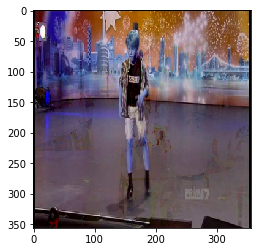

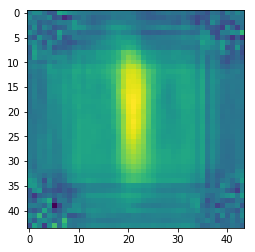

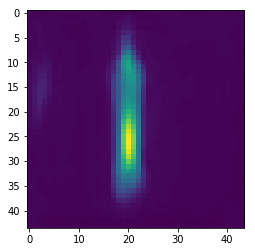

heatmap cost
Heat_loss :  14.778494
vectormap cost
Vector_loss :  75.55895




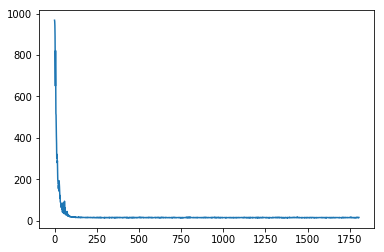

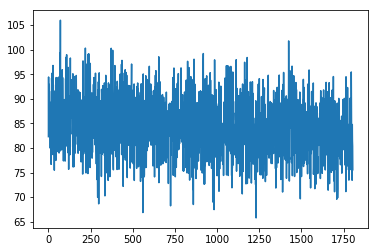

epoch 2 start


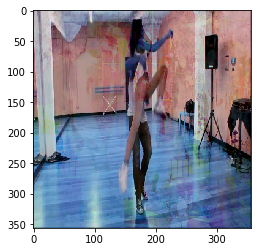

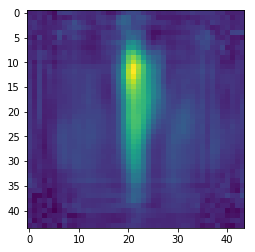

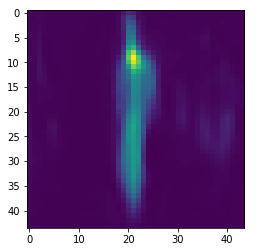

heatmap cost
Heat_loss :  14.342649
vectormap cost
Vector_loss :  77.08555




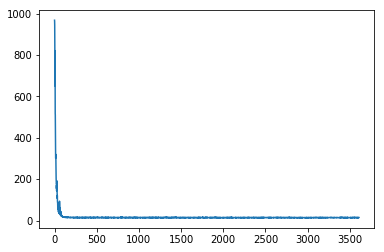

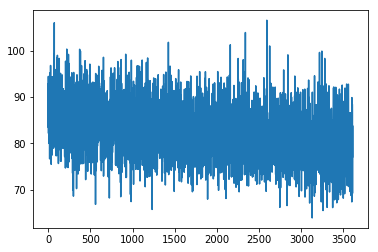

epoch 3 start


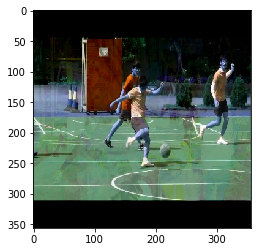

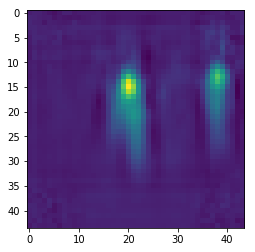

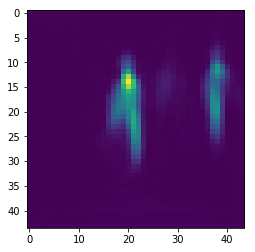

heatmap cost
Heat_loss :  14.684982
vectormap cost
Vector_loss :  86.41408




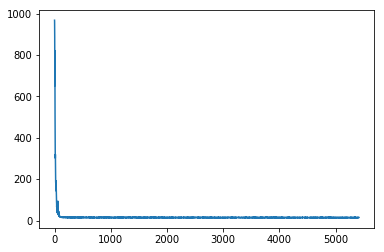

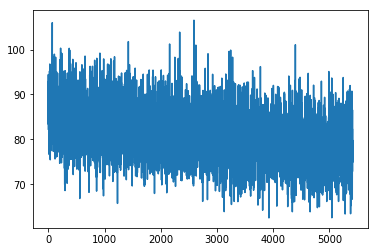

epoch 4 start


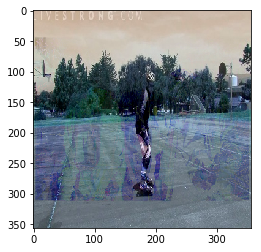

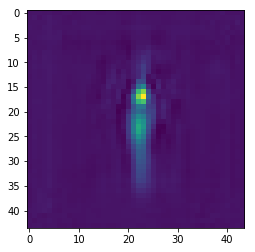

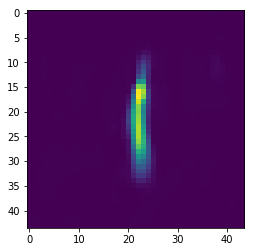

heatmap cost
Heat_loss :  13.1092415
vectormap cost
Vector_loss :  75.34742




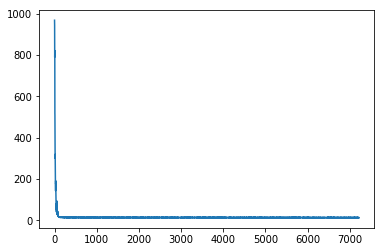

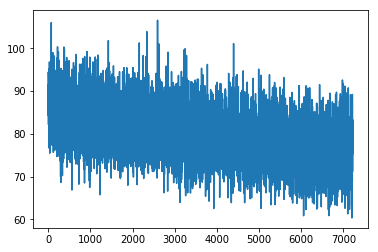

epoch 5 start


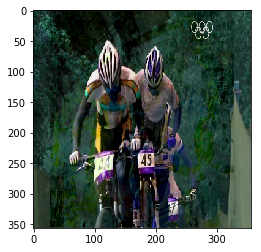

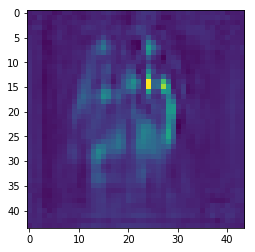

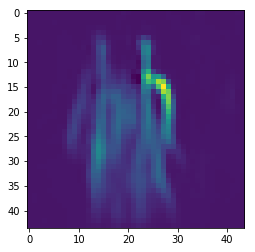

heatmap cost
Heat_loss :  14.249746
vectormap cost
Vector_loss :  80.11163




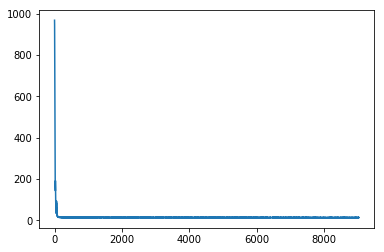

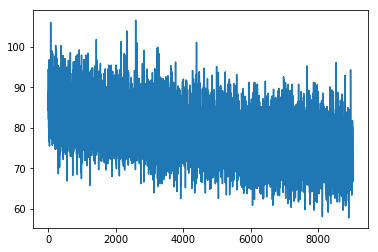

epoch 6 start


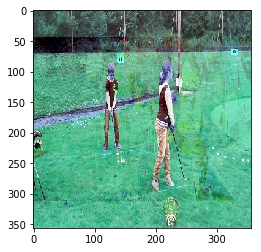

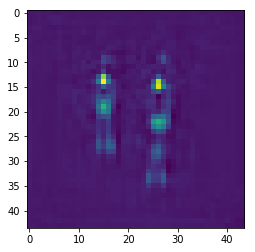

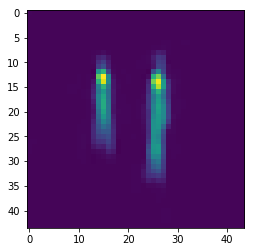

heatmap cost
Heat_loss :  13.468265
vectormap cost
Vector_loss :  64.64143




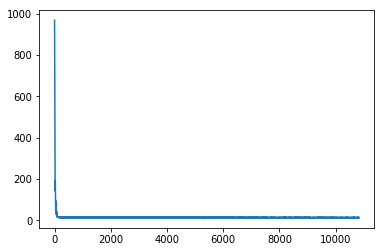

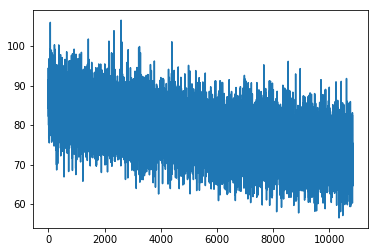

epoch 7 start


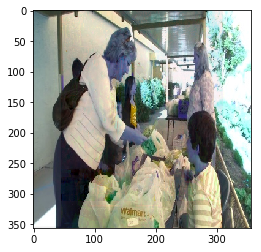

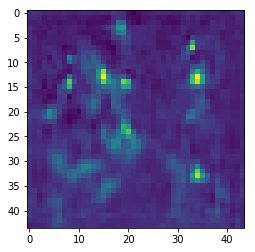

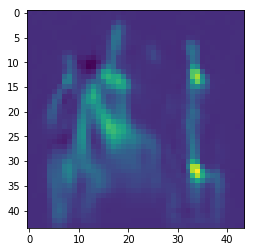

heatmap cost
Heat_loss :  12.971262
vectormap cost
Vector_loss :  77.45103




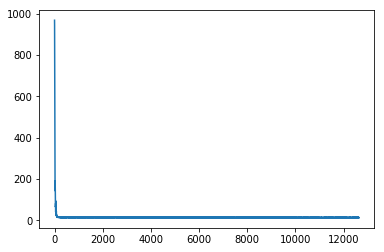

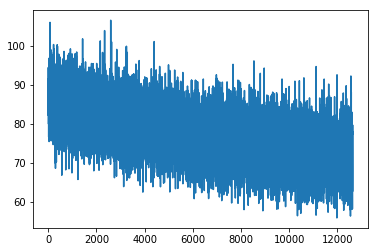

epoch 8 start


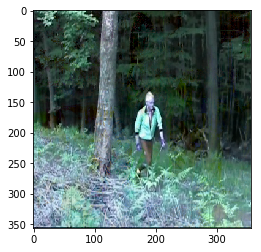

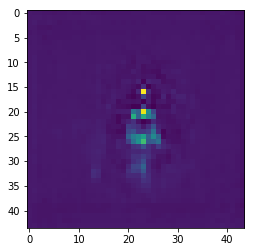

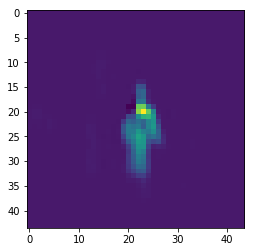

heatmap cost
Heat_loss :  13.25308
vectormap cost
Vector_loss :  72.85796




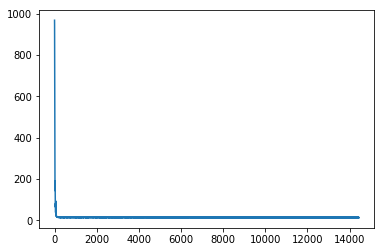

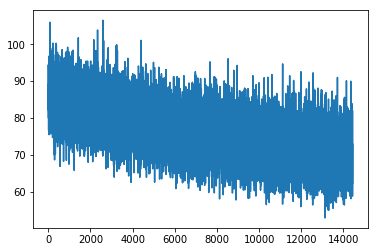

epoch 9 start


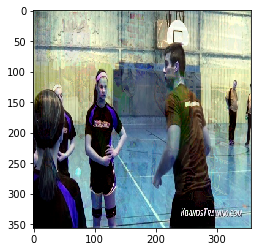

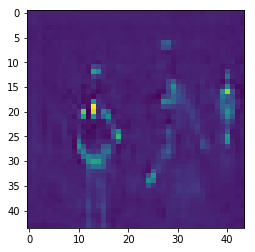

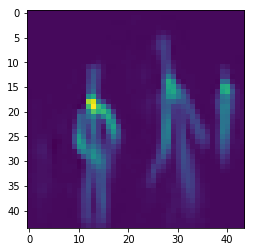

heatmap cost
Heat_loss :  13.009065
vectormap cost
Vector_loss :  70.60874




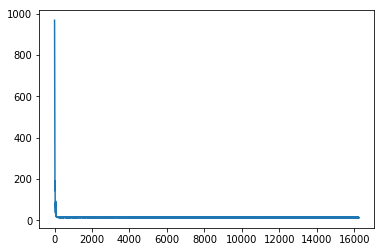

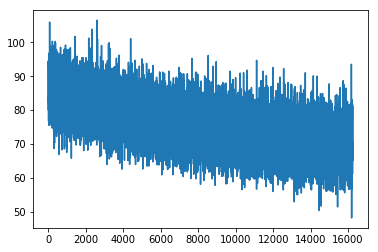

epoch 10 start


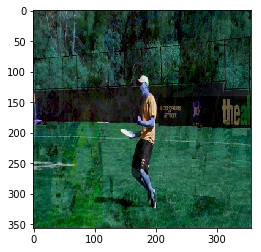

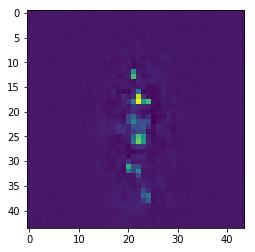

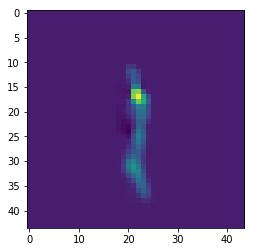

heatmap cost
Heat_loss :  11.92759
vectormap cost
Vector_loss :  51.265118




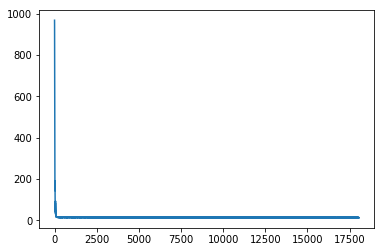

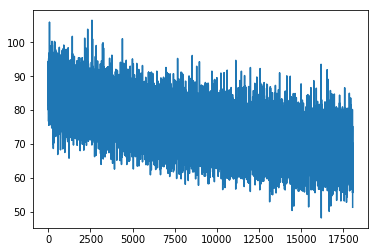

epoch 11 start


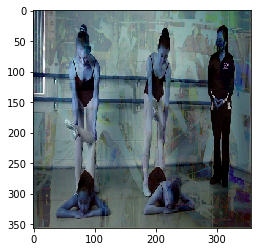

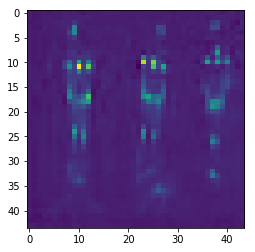

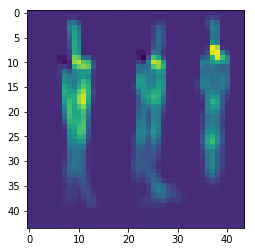

heatmap cost
Heat_loss :  13.314117
vectormap cost
Vector_loss :  69.862564




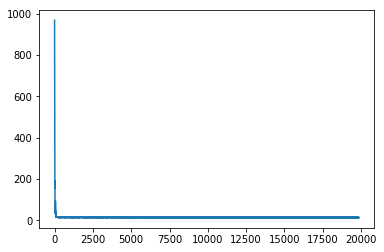

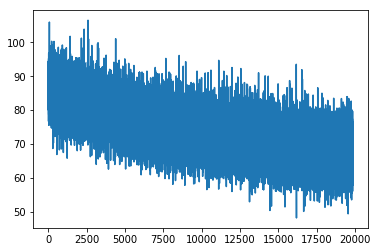

epoch 12 start


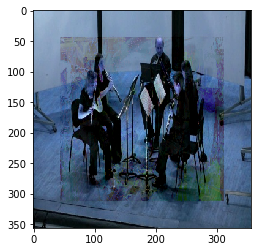

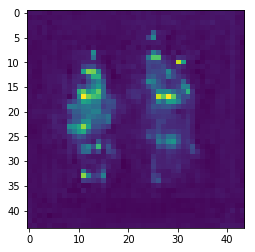

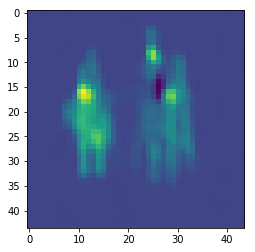

heatmap cost
Heat_loss :  12.655224
vectormap cost
Vector_loss :  64.43507




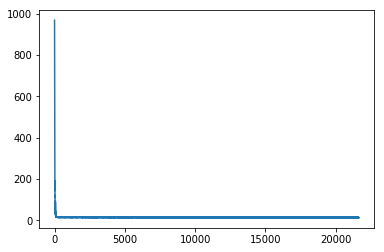

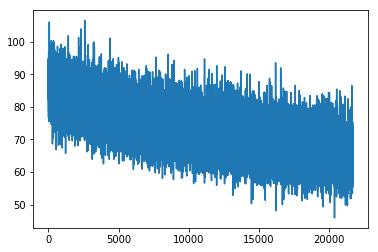

epoch 13 start


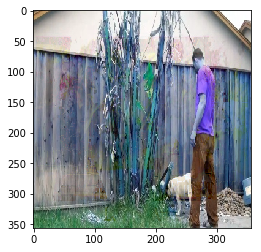

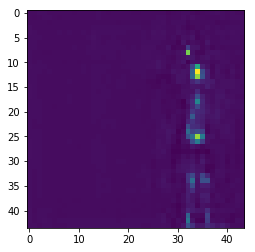

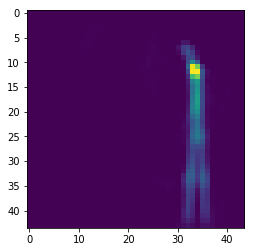

heatmap cost
Heat_loss :  13.708662
vectormap cost
Vector_loss :  71.75177




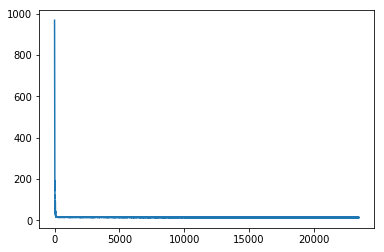

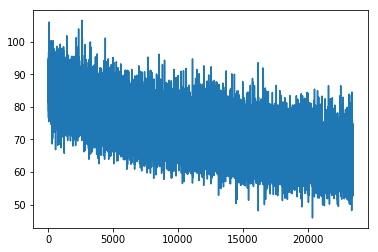

epoch 14 start


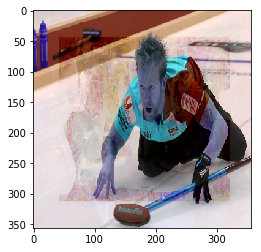

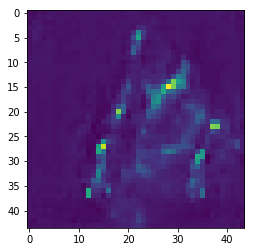

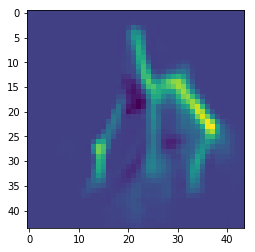

heatmap cost
Heat_loss :  13.083633
vectormap cost
Vector_loss :  69.653465




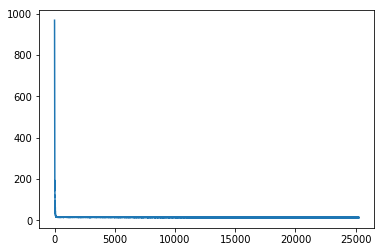

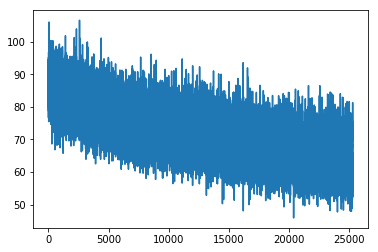

epoch 15 start


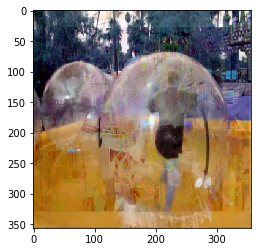

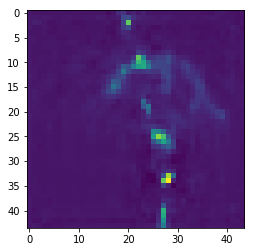

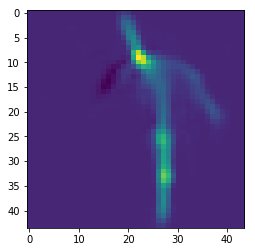

heatmap cost
Heat_loss :  12.482745
vectormap cost
Vector_loss :  66.23843




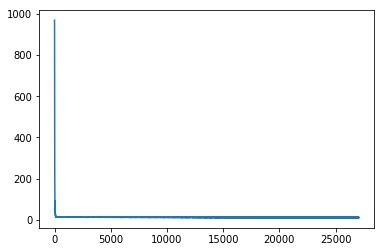

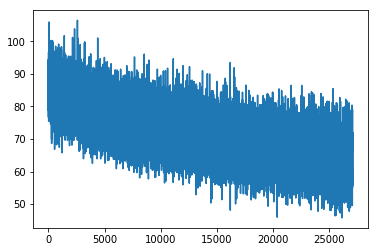

In [5]:
with tf.Session() as sess:
    obj = OpenPose(sess=sess, batch_size=16, epochs = 15)
    obj.train()

In [1]:
import sys
import numpy as np
import tensorflow as tf
from datetime import datetime
 
shape=(int(10000),int(10000))
 
with tf.device("/gpu:0"):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        print(result)

print("\n" * 2)
print("Time taken:", datetime.now() - startTime)
print("\n" * 2)


C:\Users\SimJaekyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


250046320000.0



Time taken: 0:01:45.252007



